In [9]:
import math 
import random 

import numpy as np
import pandas as pd
import pickle
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score

The scikit-learn version is 0.23.1.


In [2]:
df_data_train = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.lrn.csv', low_memory=False, sep=',')
df_data_test = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.tes.csv', low_memory=False, sep=',')

In [3]:
df_data_train.head()

ID  V1  V2  V3  V4  V5  V6  V7  V8  V9  ...  V9992  V9993  V9994  V9995  \
0   0   8   6  10   6   7   2   2   2   3  ...      1      0      0      0   
1   1  13   1  13   9   8   8   2   3   2  ...      4      1      2      1   
2   2  16   7   6   7   9   3   4   2   6  ...      0      0      0      0   
3   3   8  11  10  11   3   7   0   4   2  ...      0      0      1      0   
4   4  10  11   8   5   3   4   2   5   5  ...      0      0      0      0   

   V9996  V9997  V9998  V9999  V10000     Class  
0      0      0      0      0       0     Chell  
1      0      1      0      0       0  Engineer  
2      1      0      0      0       0     Grove  
3      0      0      2      1       0  Davisson  
4      0      0      0      0       0    Wilson  

[5 rows x 10002 columns]

## Class Distribution

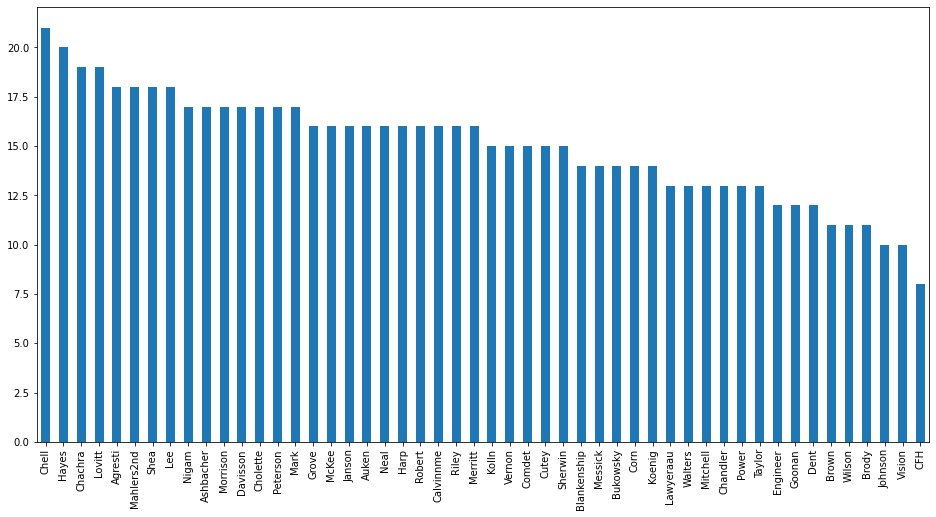

Chell          21
Hayes          20
Chachra        19
Lovitt         19
Agresti        18
Mahlers2nd     18
Shea           18
Lee            18
Nigam          17
Ashbacher      17
Morrison       17
Davisson       17
Cholette       17
Peterson       17
Mark           17
Grove          16
McKee          16
Janson         16
Auken          16
Neal           16
Harp           16
Robert         16
Calvinnme      16
Riley          16
Merritt        16
Kolln          15
Vernon         15
Comdet         15
Cutey          15
Sherwin        15
Blankenship    14
Messick        14
Bukowsky       14
Corn           14
Koenig         14
Lawyeraau      13
Walters        13
Mitchell       13
Chandler       13
Power          13
Taylor         13
Engineer       12
Goonan         12
Dent           12
Brown          11
Wilson         11
Brody          11
Johnson        10
Vision         10
CFH             8
Name: Class, dtype: int64

50

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
df_data_train['Class'].value_counts().plot(kind='bar')
plt.show()

display(df_data_train['Class'].value_counts())
display(len(df_data_train['Class'].value_counts()))

## Dataframe Pre-Processing

In [5]:
df_train = df_data_train.copy()

class_factor = df_data_train['Class'].factorize()
class_index = class_factor[1]

df_train['ClassF'] = class_factor[0]

columns = sorted(set(df_data_train.columns) - set(['ID', 'Class', 'ClassF']))

X = df_train[columns].to_numpy()
y = df_train['ClassF'].to_numpy()


X_test = df_data_test[columns]

## TDIF Transformation

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)
X_test_tfidf = tfidf.transform(X_test)


tf = TfidfTransformer(use_idf=False)
X_tf = tf.fit_transform(X)
X_test_tf = tf.fit_transform(X_test)

In [7]:
pd.DataFrame(X_test_tfidf.A).head()

0         1     2     3         4     5     6     7        8     9     \
0  0.045764  0.003592   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000   0.0   
1  0.026166  0.011552   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000   0.0   
2  0.039805  0.002604   0.0   0.0  0.006336   0.0   0.0   0.0  0.01042   0.0   
3  0.024218  0.014257   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000   0.0   
4  0.022513  0.011780   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000   0.0   

   ...  9990  9991      9992      9993      9994  9995  9996      9997  \
0  ...   0.0   0.0  0.000000  0.008537  0.008849   0.0   0.0  0.000000   
1  ...   0.0   0.0  0.036819  0.000000  0.000000   0.0   0.0  0.000000   
2  ...   0.0   0.0  0.000000  0.006188  0.000000   0.0   0.0  0.005918   
3  ...   0.0   0.0  0.022720  0.000000  0.000000   0.0   0.0  0.000000   
4  ...   0.0   0.0  0.000000  0.000000  0.000000   0.0   0.0  0.000000   

       9998      9999  
0  0.000000  0.000000  
1  0.018518  0.008549  
2  0.000000  0.000000  
3  0.011427  0.000000  
4  0.007082  0.000000  

[5 rows x 10000 columns]

## Baseline

In [28]:
df_statistical_tests = pd.DataFrame()

print('ZeroR classifier')
y_naive_pred = [np.argmax(np.bincount(y)) for i in range(0, len(y))]
df_statistical_tests = df_statistical_tests.append({
    'Type': 'Baseline (ZeroR classifier)',
    'accuracy': accuracy_score(y, y_naive_pred),
    'accuracy_sd': 0,
    'balanced_accuracy': balanced_accuracy_score(y, y_naive_pred),
    'balanced_accuracy_sd': 0,
    'f1_weighted': f1_score(y, y_naive_pred, average='weighted'),
    'f1_weighted_sd': 0,
}, ignore_index=True)


print('random guessing')
random.seed(0)
y_rand_pred = [random.randint(0, len(class_factor[1]) - 1) for i in range(0, len(y))]
df_statistical_tests = df_statistical_tests.append({
    'Type': 'Baseline (Random guessing)',
    'accuracy': accuracy_score(y, y_rand_pred),
    'accuracy_sd': 0,
    'balanced_accuracy': balanced_accuracy_score(y, y_rand_pred),
    'balanced_accuracy_sd': 0,
    'f1_weighted': f1_score(y, y_rand_pred, average='weighted'),
    'f1_weighted_sd': 0,
}, ignore_index=True)

df_statistical_tests

ZeroR classifier
random guessing


Type  accuracy  accuracy_sd  balanced_accuracy  \
0  Baseline (ZeroR classifier)  0.028000          0.0           0.020000   
1   Baseline (Random guessing)  0.018667          0.0           0.019081   

   balanced_accuracy_sd  f1_weighted  f1_weighted_sd  
0                   0.0     0.001525             0.0  
1                   0.0     0.019791             0.0

In [88]:
df_statistical_tests = pd.DataFrame()

random.seed(0)

c = OneVsRestClassifier(DummyClassifier(strategy='stratified', random_state=4))
c.fit(X_tfidf, y)

cv_result = cross_validate(c, X_tfidf, y, cv=5, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)
df_statistical_tests = df_statistical_tests = df_statistical_tests.append({
    'Type': 'Stratified',
    'accuracy': cv_result['test_accuracy'].mean(),
    'accuracy_sd': np.std(cv_result['test_accuracy']),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'balanced_accuracy_sd': np.std(cv_result['test_balanced_accuracy']),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'f1_weighted_sd': np.std(cv_result['test_f1_weighted']),
}, ignore_index=True)

c = OneVsRestClassifier(DummyClassifier(strategy='uniform'))
c.fit(X_tfidf, y)

cv_result = cross_validate(c, X_tfidf, y, cv=5, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)
df_statistical_tests = df_statistical_tests = df_statistical_tests.append({
    'Type': 'Random',
    'accuracy': cv_result['test_accuracy'].mean(),
    'accuracy_sd': np.std(cv_result['test_accuracy']),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'balanced_accuracy_sd': np.std(cv_result['test_balanced_accuracy']),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'f1_weighted_sd': np.std(cv_result['test_f1_weighted']),
}, ignore_index=True)

df_statistical_tests

Type  accuracy  accuracy_sd  balanced_accuracy  balanced_accuracy_sd  \
0  Stratified  0.017333     0.005333           0.022333              0.002906   
1      Random  0.014667     0.002667           0.020000              0.000000   

   f1_weighted  f1_weighted_sd  
0     0.004188        0.004786  
1     0.000438        0.000173

## Random Forest

In [89]:
c = OneVsRestClassifier(RandomForestClassifier())

parameter_grid_final_01 = {
    'estimator__n_estimators': [100, 200, 500, 1000],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 20, 30, 50]
}
cv_grid = GridSearchCV(c, parameter_grid_final_01, cv=5, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X_tfidf, y)


print(cv_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  4.5min
/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 146 out of 160 | elapsed: 22.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 

{'estimator__criterion': 'entropy', 'estimator__max_depth': 50, 'estimator__n_estimators': 1000}


In [92]:
selected_columns = [
    'param_estimator__n_estimators',
    'param_estimator__max_depth',
    'param_estimator__criterion',
    'mean_test_accuracy',
    'mean_test_balanced_accuracy',
    'mean_test_f1_weighted',
    'mean_fit_time'
]
df_result = pd.DataFrame(cv_grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False).head(10)[selected_columns]
df_result = df_result.rename(columns={
    "param_estimator__n_estimators": "n_estimators",
    "param_estimator__max_depth": "max_depth",
    "param_estimator__criterion": "criterion",
    "mean_test_accuracy": "accuracy",
    "mean_test_balanced_accuracy": "balanced_accuracy",
    "mean_test_f1_weighted": "f1_weighted",
    "mean_fit_time": "fit_time"
})

for col in df_result.columns:
    if df_result[col].dtype == np.float64:
        df_result[col] = df_result[col].apply(lambda x: '{0:.3f}'.format(round(x,3)))
df_result

n_estimators max_depth criterion accuracy balanced_accuracy f1_weighted  \
31         1000        50   entropy    0.683             0.679       0.659   
23         1000        20   entropy    0.677             0.673       0.653   
27         1000        30   entropy    0.676             0.672       0.653   
19         1000      None   entropy    0.673             0.672       0.645   
26          500        30   entropy    0.667             0.667       0.645   
30          500        50   entropy    0.652             0.651       0.635   
22          500        20   entropy    0.649             0.645       0.619   
18          500      None   entropy    0.633             0.632       0.609   
17          200      None   entropy    0.611             0.603       0.584   
29          200        50   entropy    0.593             0.592       0.566   

   fit_time  
31  206.842  
23  282.951  
27  262.689  
19  287.639  
26  131.611  
30  127.504  
22  146.011  
18  140.562  
17   54.528  
29   53.319

### Predict Solution

In [93]:
# Define Model

# RandomForest (TF-IDF)
c = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy'))
c.fit(X_tfidf, y)

# CV
cv_result = cross_validate(c, X_tfidf, y, cv=5, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)
df_statistical_tests = df_statistical_tests = df_statistical_tests.append({
    'Type': 'RandomForest',
    'accuracy': cv_result['test_accuracy'].mean(),
    'accuracy_sd': np.std(cv_result['test_accuracy']),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'balanced_accuracy_sd': np.std(cv_result['test_balanced_accuracy']),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'f1_weighted_sd': np.std(cv_result['test_f1_weighted']),
}, ignore_index=True)

# Predict
y_prediction = c.predict(X_test_tfidf)
y_prediction

array([36, 38, 17, 43,  1, 10,  8, 30, 27, 27, 29, 20, 45, 22, 38, 14, 15,
       45, 22, 46, 16, 32,  4,  7, 27, 23, 47, 24, 11, 42, 35, 23, 29, 15,
        6, 46, 17, 30, 27, 47, 21, 19,  8, 13, 48, 32, 21, 31, 14, 29, 33,
        7, 40, 15, 29, 22, 31,  0, 23,  1, 36, 45,  7, 40, 10,  9, 16, 18,
       45, 39, 13, 30, 34, 36, 32, 29, 25, 21, 12, 32, 45, 25, 36, 49, 40,
        1, 34, 32, 43, 31, 27, 31, 13, 39, 45, 37, 46, 18, 37, 31, 49, 38,
       43, 44, 24,  6, 10, 13, 29, 35, 20,  3, 39, 44, 24, 38, 29, 21, 44,
       31, 42, 30,  9, 31, 28, 28, 41, 25, 41, 18, 48,  1, 21, 38, 49,  8,
       34, 19, 17, 22,  2, 37, 39,  6, 24, 38, 23, 20, 17,  1, 13,  9, 29,
       45, 17, 25, 43,  1, 25, 46, 45, 29,  0, 47, 39, 36, 37, 46,  6, 17,
       49, 29, 49, 34,  4, 18, 39, 27,  2, 29,  8,  7, 14, 45, 17, 10, 19,
       30, 12, 21, 11,  6, 44, 17,  2, 26, 24, 41, 15, 27, 19, 21, 28, 31,
       39, 24, 36, 15,  6, 12, 21, 41, 39, 44, 17, 15, 31, 27, 42, 37, 15,
       10,  3, 21, 23, 10

In [94]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

df_solution_test.to_csv('solution_rf.csv')

display(df_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()

Class
ID               
750   Blankenship
751         Hayes
752        Goonan
753          Dent
754      Engineer
...           ...
1495        Power
1496      Agresti
1497    Lawyeraau
1498        Grove
1499    Ashbacher

[750 rows x 1 columns]

## SVC

In [95]:
if False:
    c = OneVsRestClassifier(SVC())

    # Run 01
    parameter_grid_final_01 = {
        'estimator__C': [math.pow(2, x) for x in range(-5, 15)]
    }
    cv_grid = GridSearchCV(c, parameter_grid_final_01, cv=5, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit=False)
    cv_grid.fit(X_tfidf, y)

    pickle.dump(cv_grid.cv_results_, open( "cv_results_final_01.p", "wb" ))

    # Run 02
    parameter_grid_final_02 = {
        'estimator__C': [x for x in np.linspace(start = 8, stop = 16, num = 25)]
    }
    cv_grid = GridSearchCV(c, parameter_grid_final_02, cv=5, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit=False)
    cv_grid.fit(X_tfidf, y)

    pickle.dump(cv_grid.cv_results_, open( "cv_results_final_02.p", "wb" ))

    # Run 03
    parameter_grid_final_03 = {
        'estimator__C': [x for x in np.linspace(start = 9.3, stop = 9.9, num = 25)]
    }
    cv_grid = GridSearchCV(c, parameter_grid_final_03, cv=5, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit=False)
    cv_grid.fit(X_tfidf, y)

    pickle.dump(cv_grid.cv_results_, open( "cv_results_final_03.p", "wb" ))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.5min
/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:  6.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  7.3min remaining:   43.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 107 out of 125 | elapsed:  8.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 125 | elapsed: 10.0min remaining:   25.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 107 out of 125 | elapsed:  9.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 125 | elapsed: 10.2min remaining:   25.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.3min finished


{'estimator__C': 16.0}
{'estimator__C': 16.0}
{'estimator__C': 16.0}
mean_fit_time = 56.65633964538574s
mean_score_time = 14.333383779525757s


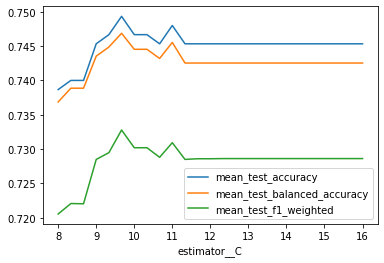

{'estimator__C': 9.666666666666666}
{'estimator__C': 9.666666666666666}
{'estimator__C': 9.666666666666666}
mean_fit_time = 60.477017438888545s
mean_score_time = 15.208121032714844s


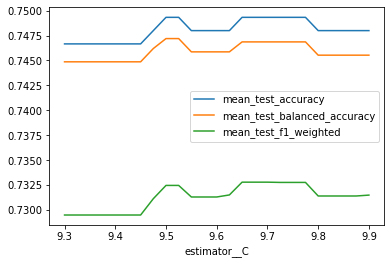

{'estimator__C': 9.5}
{'estimator__C': 9.5}
{'estimator__C': 9.5}
mean_fit_time = 61.31077702522279s
mean_score_time = 15.367427507400512s


In [96]:
# Run 01
cv_results = pickle.load(open( "cv_results_final_01.p", "rb" ))
df_cv_results = pd.DataFrame(cv_results['params'])
df_cv_results['mean_test_accuracy'] = cv_results['mean_test_accuracy']
df_cv_results['mean_test_balanced_accuracy'] = cv_results['mean_test_balanced_accuracy']
df_cv_results['mean_test_f1_weighted'] = cv_results['mean_test_f1_weighted']
df_cv_results.set_index('estimator__C').plot()
plt.show()

print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print('mean_fit_time = %ss' % cv_results['mean_fit_time'].mean())
print('mean_score_time = %ss' % cv_results['mean_score_time'].mean())

# Run 02
cv_results = pickle.load(open( "cv_results_final_02.p", "rb" ))
df_cv_results = pd.DataFrame(cv_results['params'])
df_cv_results['mean_test_accuracy'] = cv_results['mean_test_accuracy']
df_cv_results['mean_test_balanced_accuracy'] = cv_results['mean_test_balanced_accuracy']
df_cv_results['mean_test_f1_weighted'] = cv_results['mean_test_f1_weighted']
df_cv_results.set_index('estimator__C').plot()
plt.show()

print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print('mean_fit_time = %ss' % cv_results['mean_fit_time'].mean())
print('mean_score_time = %ss' % cv_results['mean_score_time'].mean())

# Run 03
cv_results = pickle.load(open( "cv_results_final_03.p", "rb" ))
df_cv_results = pd.DataFrame(cv_results['params'])
df_cv_results['mean_test_accuracy'] = cv_results['mean_test_accuracy']
df_cv_results['mean_test_balanced_accuracy'] = cv_results['mean_test_balanced_accuracy']
df_cv_results['mean_test_f1_weighted'] = cv_results['mean_test_f1_weighted']
df_cv_results.set_index('estimator__C').plot()
plt.show()

print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print(cv_results['params'][cv_results['mean_test_accuracy'].argmax()])
print('mean_fit_time = %ss' % cv_results['mean_fit_time'].mean())
print('mean_score_time = %ss' % cv_results['mean_score_time'].mean())

### Predict Solution

In [97]:
# Define Model

# SVC (TF-IDF)
c = OneVsRestClassifier(SVC(C=9.75, kernel='rbf'))
c.fit(X_tfidf, y)

# CV
cv_result = cross_validate(c, X_tfidf, y, cv=5, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)
df_statistical_tests = df_statistical_tests = df_statistical_tests.append({
    'Type': 'SVC',
    'accuracy': cv_result['test_accuracy'].mean(),
    'accuracy_sd': np.std(cv_result['test_accuracy']),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'balanced_accuracy_sd': np.std(cv_result['test_balanced_accuracy']),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'f1_weighted_sd': np.std(cv_result['test_f1_weighted']),
}, ignore_index=True)

# Predict
y_prediction = c.predict(X_test_tfidf)
y_prediction

array([36, 38, 17, 43,  1, 10,  8, 30, 27, 27, 29, 20,  3, 22, 49, 42,  4,
       45, 22, 46, 16, 32, 26,  7,  9, 23, 47, 24, 11, 42, 35, 23, 29, 15,
        4, 27, 42, 30, 27, 47, 21, 19,  8, 13, 46, 20, 21, 31, 10, 23, 42,
        7, 37, 15, 21, 22, 31, 48, 23,  1, 29, 17,  7, 40, 10, 19, 16, 18,
       45, 39, 28, 30, 34, 36, 32, 29, 25, 21,  6, 32, 45, 25, 36, 49, 40,
        1, 10, 41, 43, 43, 27, 31, 44, 39, 45,  3, 46, 18, 37, 45, 49, 26,
       43, 44,  6, 35, 10, 18, 29, 35, 20,  3, 39, 44, 19, 49, 34, 15, 44,
       31, 42, 30, 42, 31, 28, 28, 13, 25, 41, 22, 48,  1, 21, 12, 49,  8,
       34, 19, 17, 22,  2, 12, 39, 16,  9, 38, 23, 20, 14,  1, 15, 42,  5,
       45, 15, 25, 43, 34, 20, 46,  3, 26, 24, 22, 39, 36,  7, 46, 22, 17,
       35, 29, 49, 34,  4, 18, 39, 42,  2, 29,  8,  7, 14, 42, 17, 42, 41,
       30, 12, 21, 11, 22, 15, 17,  2, 26, 23, 41, 15, 28, 19,  3, 28, 31,
       39, 24, 36, 15,  2, 12,  9, 41, 39, 44, 17, 15, 31, 11, 42, 26, 15,
       10,  3, 21, 23, 10

In [98]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

df_solution_test.to_csv('solution_scv.csv')

display(df_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()

Class
ID               
750   Blankenship
751         Hayes
752        Goonan
753          Dent
754      Engineer
...           ...
1495         Corn
1496     Engineer
1497    Lawyeraau
1498        Grove
1499       Janson

[750 rows x 1 columns]

## Significance Test

In [105]:
df_statistical_tests_complete = df_statistical_tests.copy()

# manually added NN
# {'Type': 'MLP', 'accuracy': 0.5213333333333334, 'accuracy_sd': 0.07767739553935739, 'balanced_accuracy': 0.5451999706501985, 'balanced_accuracy_sd': 0.09052941677932276, 'f1_weighted': 0.5307219835645299, 'f1_weighted_sd': 0.06309686135159005}
# {'Type': 'MLP', 'accuracy': 0.5586666666666666, 'accuracy_sd': 0.024367555843329426, 'balanced_accuracy': 0.5736905867547964, 'balanced_accuracy_sd': 0.031285639980511856, 'f1_weighted': 0.548488111888112, 'f1_weighted_sd': 0.027700231785569577}
df_statistical_tests_complete = df_statistical_tests_complete.append({
    'Type': 'MLP (50 epochs)',
    'accuracy': 0.5213333333333334,
    'accuracy_sd': 0.07767739553935739,
    'balanced_accuracy': 0.5451999706501985,
    'balanced_accuracy_sd': 0.09052941677932276,
    'f1_weighted': 0.5307219835645299,
    'f1_weighted_sd': 0.06309686135159005,
}, ignore_index=True)
df_statistical_tests_complete = df_statistical_tests_complete.append({
    'Type': 'MLP (200 epochs)',
    'accuracy': 0.5586666666666666,
    'accuracy_sd': 0.024367555843329426,
    'balanced_accuracy': 0.5736905867547964,
    'balanced_accuracy_sd': 0.031285639980511856,
    'f1_weighted': 0.548488111888112,
    'f1_weighted_sd': 0.027700231785569577,
}, ignore_index=True)

df_statistical_tests_complete = df_statistical_tests_complete.set_index('Type')
display(df_statistical_tests_complete)
print()
print()
print()


measure = 'balanced_accuracy'

df_statistical_tests_all =  df_statistical_tests_complete.tail(4).copy()[[measure, '%s_sd' % measure]]
df_statistical_tests_all['%s(Stratified)' % measure] = df_statistical_tests_complete.iloc[0][measure]
df_statistical_tests_all['%s(Random)' % measure] = df_statistical_tests_complete.iloc[1][measure]
df_statistical_tests_all['%s(RandomForest)' % measure] = df_statistical_tests_complete.iloc[2][measure]


# H0, mean of balanced_accuracy (paper) is the same as classifier balanced_accuracy
# Two-tailed t-distribution with confidence level 95%
# Degrees of freedom N-1 = 4


t9_95 = 2.776
N = 5 # (5-fold CV)

print('Compare against balanced_accuracy(ZeroR)')
df_statistical_tests_all['t-value'] = (df_statistical_tests_all[measure] - df_statistical_tests_all['%s(Stratified)' % measure]) / (df_statistical_tests_all['%s_sd' % measure] / np.full(df_statistical_tests_all.shape[0], np.sqrt(N)))
df_statistical_tests_all['h0'] = (np.abs(df_statistical_tests_all['t-value']) < t9_95).apply(lambda x: 'keep' if x else 'reject')
display(df_statistical_tests_all[['balanced_accuracy(Stratified)', 'balanced_accuracy', 'balanced_accuracy_sd', 't-value', 'h0']])
print()


print('Compare against balanced_accuracy(RandomForest)')
df_statistical_tests_all['t-value'] = (df_statistical_tests_all[measure] - df_statistical_tests_all['%s(RandomForest)' % measure]) / (df_statistical_tests_all['%s_sd' % measure] / np.full(df_statistical_tests_all.shape[0], np.sqrt(N)))
df_statistical_tests_all['h0'] = (np.abs(df_statistical_tests_all['t-value']) < t9_95).apply(lambda x: 'keep' if x else 'reject')
display(df_statistical_tests_all[['balanced_accuracy(RandomForest)', 'balanced_accuracy', 'balanced_accuracy_sd', 't-value', 'h0']].tail(3))
print()

accuracy  accuracy_sd  balanced_accuracy  \
Type                                                         
Stratified        0.017333     0.005333           0.022333   
Random            0.014667     0.002667           0.020000   
RandomForest      0.653333     0.018379           0.653067   
SVC               0.749333     0.010832           0.746867   
MLP (50 epochs)   0.521333     0.077677           0.545200   
MLP (200 epochs)  0.558667     0.024368           0.573691   

                  balanced_accuracy_sd  f1_weighted  f1_weighted_sd  
Type                                                                 
Stratified                    0.002906     0.004188        0.004786  
Random                        0.000000     0.000438        0.000173  
RandomForest                  0.021146     0.626803        0.021827  
SVC                           0.020697     0.732755        0.013374  
MLP (50 epochs)               0.090529     0.530722        0.063097  
MLP (200 epochs)              0.031286     0.548488        0.027700




Compare against balanced_accuracy(ZeroR)


balanced_accuracy(Stratified)  balanced_accuracy  \
Type                                                                 
RandomForest                           0.022333           0.653067   
SVC                                    0.022333           0.746867   
MLP (50 epochs)                        0.022333           0.545200   
MLP (200 epochs)                       0.022333           0.573691   

                  balanced_accuracy_sd    t-value      h0  
Type                                                       
RandomForest                  0.021146  66.694932  reject  
SVC                           0.020697  78.275825  reject  
MLP (50 epochs)               0.090529  12.914756  reject  
MLP (200 epochs)              0.031286  39.406971  reject


Compare against balanced_accuracy(RandomForest)


balanced_accuracy(RandomForest)  balanced_accuracy  \
Type                                                                   
SVC                                      0.653067           0.746867   
MLP (50 epochs)                          0.653067           0.545200   
MLP (200 epochs)                         0.653067           0.573691   

                  balanced_accuracy_sd    t-value      h0  
Type                                                       
SVC                           0.020697  10.133795  reject  
MLP (50 epochs)               0.090529  -2.664297    keep  
MLP (200 epochs)              0.031286  -5.673220  reject